# Graph Auto-Encoders

## Introduction
This tutorial demonstrates the use of Graph Auto-Encoders (GAEs) and Variational Graph Auto-Encoders (VGAEs) to perform unsupervised learning on a graph. The models will be implemented with PyTorch and PyG (torch geometric) (a <a href='https://github.com/tkipf/gae'>tensorflow implementation</a> has been produced by the author of VGAE).
To demonstrate the suitably of the models' embeddings, we show how unsupervised training using only the reconstruction loss improves performance on a link prediction task that the model is not directly optimising for.

## Setup
Here we load required libraries, define paths to data, and define some helper functions. **Feel free to skip this section.**

In [23]:
import torch
import igraph as ig
import random
from datetime import datetime
from PIL import Image
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.datasets import *
from tensorboardX import SummaryWriter
from torch_geometric.nn.models.autoencoder import EPS, MAX_LOGVAR
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.utils import to_networkx, train_test_split_edges
from torch_geometric.data import Data
from torch_geometric.nn.inits import reset
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from pandas import DataFrame as df
import numpy as np
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.utils import (negative_sampling, remove_self_loops, add_self_loops)

In [21]:
# define the path to save datasets
fp_data = "./datasets/"

## Load data

### PubMed
The PubMed graph is accessible through PyG

In [84]:
# load the dataset - small download on first run
dataset_name = "Citeseer"  # options: 'Citeseer', 'Cora', 'PubMed'
dataset = Planetoid(root="./datasets/"+dataset_name, name=dataset_name)
data = dataset[0]

In [85]:
# explore key features of the graph
print('num nodes =', data.num_nodes)
print('num edges =', data.num_edges)
print('num features =', data.num_node_features)

num nodes = 3327
num edges = 9104
num features = 3703


<strong>Useful PyG Data class attributes</strong>
<table width="75%">
    <header>
        <th style="text-align:left">Name</th>
        <th style="text-align:left">Attribute</th>
        <th style="text-align:left">Shape</th>
    </header>
    <tr>
        <td style="text-align:left">Node Feature Matrix</td>
        <td style="text-align:left">data.x</td>
        <td style="text-align:left">(num nodes, num features)</td>
    </tr>
    <tr>
        <td style="text-align:left">Edge Index</td>
        <td style="text-align:left">data.edge_index</td>
        <td style="text-align:left">(2, num edges)</td>
    </tr>
    <tr>
        <td style="text-align:left">Node Classes</td>
        <td style="text-align:left">data.y</td>
        <td style="text-align:left">(num nodes, )</td>
    </tr>
</table>

## Visualisation

In [96]:
# define a plot function using networkx
def plot(data, outfile='./graph.eps'):
    """
    plot a PyG graph using igraph
    :param data: instance of torch_geometric.data
    """
    assert data.edge_index is not None, 'cannot plot after train_test_split_edges has been called'
    g = ig.Graph()
    # set the number of vertices
    g.add_vertices(data.num_nodes)
    # get the edges as a list of tuples [(source, target) ...]
    edges = list(zip(*tuple(data.edge_index)))
    edges = [(int(a), int(b)) for a, b in edges]
    g.add_edges(edges)
    n_classes = len(np.unique(data.y))
    # randomly generate a hexadecimal colour for each class
    r = lambda: random.randint(0, 255)
    colours = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(n_classes)]
    g.vs['color'] = [colours[cls] for cls in data.y]
    # save the plot to a .eps file
    ig.plot(
        g, outfile,
        layout=g.layout_auto(), vertex_size=15, vertex_colour='#D1D1D1',
        edge_curved=True, bbox=(3000, 3000), margin=20
    )
    # read and show the plot
    img = Image.open(outfile)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

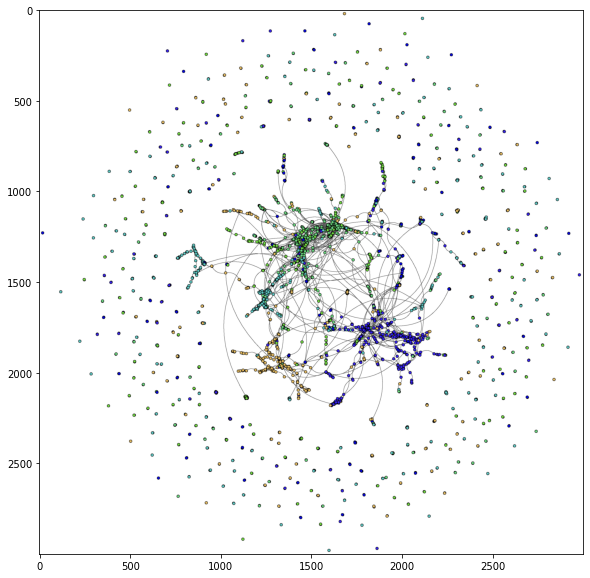

In [97]:
# plot the graph - ok to run on cora/citeseer but slower on pubmed
if dataset_name != 'PubMed':
    plot(data)

## Prepare data for edge prediction

In [64]:
# To perform edge prediction, we need to split the graph's edges intro train and test sets
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
# Note that data.edge_index is no longer available, as edges have been distributed between train and test
print('num train edges', data.train_pos_edge_index.shape[1])

num train edges 7740


In [65]:
# Get the device to use for training our model
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA available:', torch.cuda.is_available())

CUDA available: True


In [66]:
# We then register the relevant data to the device in use
x = data.x.to(dev)  # feature matrix
train_pos_edge_index = data.train_pos_edge_index.to(dev)  # index of true positive edges in the train set


## GAE Model
To understand GAEs, we show the models as constructed by PyG. Alternatively, these can be imported directly from torch_geometric.nn
 
Importantly, the GAE class includes methods to:
<ul>
    <li>apply the encoder and decoder</li>
    <li>calculate reconstruction loss</li>
</ul>

In [67]:
# define the GAE class

class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)

        neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


In [68]:
# define the encoder and decoder that GAE will use
# this code is slightly adapted from the PyG example to accept model_name
class GAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

In [69]:
# To decode embeddings and attempt input reconstruction, we can use the standard InnerProductDecoder
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj

In [70]:
# bring the encoder and decoder together to compile the GAE
# in_channels (the dimensionality of the input data) is simply the number of features
# we define out_channels (the dimensionality of the latent vector or embedding) as 16
model = GAE(GAEEncoder(in_channels=dataset.num_features, out_channels=2)).to(dev)

In [71]:
# define the optimizer with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
# define a writer to log training results
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

Although we will train the GAE in an unsupervised manner (using reconstruction loss) <i>we can validate it's performance by testing it's ability to perform link prediction during training </i> (even though this is not used in back propagation).

In [73]:
# define a function to test our predictions against the ground truth edges
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [74]:
# train the model
for epoch in range(0, 1000):
    optimizer.zero_grad()
    # get the embedding (z) of each node, shape(num_nodes, channels)
    z = model.encode(x, train_pos_edge_index)
    # calculate the reconstruction loss to be used in backprop
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()

    writer.add_scalar("loss", loss.item(), epoch)
    
    # calculate performance on edge prediction task
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 100 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 000, AUC: 0.6618, AP: 0.7057
Epoch: 100, AUC: 0.7940, AP: 0.8092
Epoch: 200, AUC: 0.7914, AP: 0.8037
Epoch: 300, AUC: 0.7910, AP: 0.8067
Epoch: 400, AUC: 0.7845, AP: 0.8036
Epoch: 500, AUC: 0.7805, AP: 0.7964
Epoch: 600, AUC: 0.7749, AP: 0.7971
Epoch: 700, AUC: 0.7723, AP: 0.7966
Epoch: 800, AUC: 0.7735, AP: 0.7960
Epoch: 900, AUC: 0.7700, AP: 0.7946


## VGAE Model
To understand VGAEs, we again show the model as constructed by PyG (torch_geometric.nn.VGAE).
 
VGAE differs from GAE in the use of two GCNs that encode the mean and variance. This allows it to reconstruct unseen inputs but requires a few updates to the main class.
Namely:
<ul>
    <li>we use a KL loss, which uses the reconstruction loss from GAEs but adds a term to measure the probability distributions</li>
    <li>the encoder uses the reparametrisation trick in order to maintain a differentiable loss function </li>
</ul>

In [75]:
# define the VGAE class, which inherits from GAE 

class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(VGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logvar):
        if self.training:
            return mu + torch.randn_like(logvar) * torch.exp(logvar)
        else:
            return mu

    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logvar__ = self.encoder(*args, **kwargs)
        self.__logvar__ = self.__logvar__.clamp(max=MAX_LOGVAR)
        z = self.reparametrize(self.__mu__, self.__logvar__)
        return z

    def kl_loss(self, mu=None, logvar=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logvar`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logvar (Tensor, optional): The latent space for
                :math:`\log\sigma^2`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logvar = self.__logvar__ if logvar is None else logvar.clamp(
            max=MAX_LOGVAR)
        return -0.5 * torch.mean(
            torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1))

In [76]:
# define a new encoder which incorporates new GCN layers for embedding the probability distribution
class VGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logvar = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)

In [77]:
# bring the encoder and decoder together to compile the VGAE
# in_channels (the dimensionality of the input data) is simply the number of features
# we define out_channels (the dimensionality of the latent vector or embedding) as 16
model = VGAE(VGAEEncoder(in_channels=dataset.num_features, out_channels=2)).to(dev)

In [78]:
# redefine the optimizer in order to reset it from the GAE training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [79]:
for epoch in range(1000):
    optimizer.zero_grad()
    # get the embedding (z) of each node, shape(num_nodes, channels)
    z = model.encode(x, train_pos_edge_index)
    # calculate reconstruction loss
    recon_loss = model.recon_loss(z, train_pos_edge_index)
    # calculate kl loss
    kl_loss = model.kl_loss()
    # multiply the two losses, ensuring output is nonzero
    loss = recon_loss + (1 / data.num_nodes) * kl_loss
    loss.backward()
    optimizer.step()

    writer.add_scalar("loss", loss.item(), epoch)
    
    # calculate performance on edge prediction task
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 100 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 000, AUC: 0.6200, AP: 0.6292
Epoch: 100, AUC: 0.7821, AP: 0.7917
Epoch: 200, AUC: 0.7931, AP: 0.8058
Epoch: 300, AUC: 0.7871, AP: 0.8029
Epoch: 400, AUC: 0.7833, AP: 0.8083
Epoch: 500, AUC: 0.7832, AP: 0.8074
Epoch: 600, AUC: 0.7921, AP: 0.8106
Epoch: 700, AUC: 0.8007, AP: 0.8170
Epoch: 800, AUC: 0.7976, AP: 0.8165
Epoch: 900, AUC: 0.7934, AP: 0.8140
